## Постановка задачи
Разберем архитектуру VGG для решения задач распознавания изображений. Применим их для анализа исходных изображений.

Используя веса обученной модели и обучим линейный слой поверх существующей модели. Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

© ITtensive, 2020

![](vgg16.jpg)

### Подключение библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Flatten, Activation
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import optimizers
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Using TensorFlow backend.


### Используемые функции

In [2]:
batch_size = 20
filesDir = "train_images_small"
image_x = 224 # 525
image_y = 224 # 350
image_ch = 3 # 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(len(df), 1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        img = image.load_img(os.path.join(filesDir, file),
                     target_size=(image_y, image_x))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        x[j] = preprocess_input(img)
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size   
            batch_end += batch_size

def draw_prediction (prediction):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1,1,1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()

### Загрузка данных

In [3]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [4]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [5]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

                                           EncodedPixels        Image Label
20588  227313 3 227321 9 227332 1 227335 2 227338 1 2...  ed308d4.jpg  Fish
10936                                                NaN  7c6474b.jpg  Fish
2492                                                 NaN  1bb3c7a.jpg  Fish
18864                                                NaN  da6473a.jpg  Fish
4316   396958 314 398358 314 399758 314 401158 314 40...  31226bb.jpg  Fish


### VGG16
Используем обученную нейросеть для классификации "неизвестных" изображений - облаков

Для построения модели потребуются рассчитанные веса: 527 Мб данных.

In [6]:
vgg16 = VGG16(weights='imagenet', include_top=False,
             input_shape=(image_y, image_x, image_ch))

In [7]:
layers = Flatten()(vgg16.output)
layers = Activation("softmax")(layers)
model = Model(inputs=vgg16.input, outputs=Dense(1)(layers))
for layer in vgg16.layers:
    layer.trainable = False
model.compile(optimizer=optimizers.Nadam(lr=0.05),
             loss="mean_absolute_error")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
model.fit_generator(load_data(train, batch_size),
            epochs=50, steps_per_epoch=len(train)//batch_size)

Epoch 1/10
221/221 [==============================] - 3237s 15s/step - loss: 0.4575
Epoch 2/10
221/221 [==============================] - 3191s 14s/step - loss: 0.4690
Epoch 3/10
221/221 [==============================] - 3502s 16s/step - loss: 0.4628
Epoch 4/10
221/221 [==============================] - 3380s 15s/step - loss: 0.4655
Epoch 5/10
221/221 [==============================] - 3769s 17s/step - loss: 0.4630
Epoch 6/10
221/221 [==============================] - 3340s 15s/step - loss: 0.4639
Epoch 7/10
221/221 [==============================] - 3390s 15s/step - loss: 0.4596
Epoch 8/10
221/221 [==============================] - 3610s 16s/step - loss: 0.4631
Epoch 9/10
221/221 [==============================] - 4163s 19s/step - loss: 0.4645
Epoch 10/10
221/221 [==============================] - 3658s 17s/step - loss: 0.4627


### Построение предсказания

In [11]:
prediction = model.predict_generator(load_data(test, 1),
                            steps=len(test), verbose=1)

1110/1110 [==============================] - 1120s 1s/step


In [12]:
prediction = np.transpose(prediction)

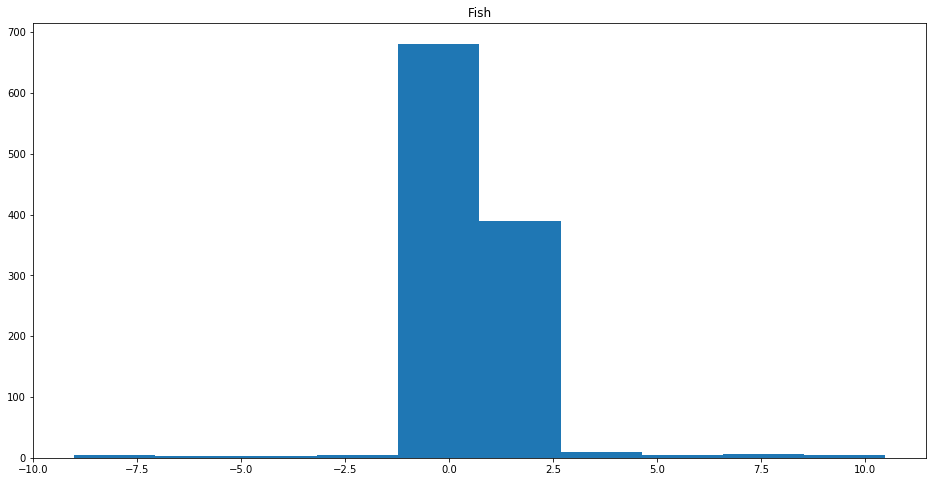

In [13]:
draw_prediction(prediction)

In [19]:
test["target"] = np.round(prediction[0]>5).astype("int8")
print (test[test["target"]>0][["EncodedPixels","target"]])

                                           EncodedPixels  target
18428                                                NaN       1
13788                                                NaN       1
3244                                                 NaN       1
8164   1286000 590 1287400 590 1288800 590 1290200 59...       1
22044  852912 515 854312 515 855712 515 857112 515 85...       1
8112                                                 NaN       1
13680  74564 440 75964 440 77364 440 78764 440 80164 ...       1
8700   719624 629 721024 629 722424 629 723824 629 72...       1
11296  25753 713 27153 713 28553 713 29953 713 31353 ...       1
3176   1 506 1401 506 2801 506 4201 506 5601 506 7001...       1
21676  650 269 2050 269 3450 269 4850 269 6250 269 76...       1
5692   34258 523 35658 523 37058 523 38458 523 39858 ...       1
11372  394116 266 394385 5 395516 260 395777 13 39691...       1
1616   2262157 238 2263557 238 2264957 238 2266357 23...       1


### Расчет точности предсказания
Нет облаков - 0.5, MLP - 0.3, CONV - 0.48, AlexNet - 0.2

In [20]:
dice = test.apply(calc_dice, axis=1, result_type="expand")
print ("Keras, VGG16:", round(dice.mean(), 3))

Keras, VGG16: 0.496
